In [220]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from keras.models import Sequential
from keras.layers import Dense

import matplotlib.pyplot as plt
from random import randint

pd.set_option('display.max_rows', 1000)

# Parameters

In [221]:
file_path_desc = "D:/Data challenge/columns_description.xlsx"
file_path_data = "D:/Data challenge/competition_table.xlsx"

# Data input

In [222]:
data = pd.read_excel(file_path_data)

data = data[data['odds_home_team_win']!=0].reset_index(drop = True)
# remove odds =0 cases odds_home_team_win, 7 darab

data.head() 
# Ötletek:
# div bontás,odds pontosság features, odds alapján score hozzánézni eredményt, attack defense feature idő alapon - div és season használat
# random forest, NB, xg

,match_id,season,div,odds_home_team_win,odds_draw,odds_away_team_win,home_team_match_nr,home_team_goal_roll1_sum,home_team_goal_roll2_sum,home_team_goal_roll3_sum,...,odds_away_team_draw_roll4_mean,odds_away_team_defeat_roll1_mean,odds_away_team_defeat_roll2_mean,odds_away_team_defeat_roll3_mean,odds_away_team_defeat_roll4_mean,away_team_point_mean,away_team_expected_point_mean,home_win_flag,draw_flag,away_win_flag
0,0,2008-2009,div0,1.73,3.5,5.00,5,3,7,8,...,3.825,11.00,7.665,6.377,5.908,0.500,3.0,0,0,1
1,1,2008-2009,div0,1.25,5.5,12.00,7,0,2,5,...,3.582,2.10,2.250,2.833,2.475,0.333,0.0,0,1,0
2,2,2008-2009,div0,1.57,3.8,5.75,9,1,4,4,...,3.525,6.75,4.275,3.883,3.638,0.750,1.5,1,0,0
3,3,2008-2009,div0,1.17,7.0,15.00,11,2,6,7,...,3.975,4.20,2.750,2.333,2.550,0.600,0.0,1,0,0
4,4,2008-2009,div0,1.17,7.0,15.00,14,2,4,7,...,3.925,3.10,2.175,2.050,2.015,0.833,0.0,1,0,0


# EDA

In [223]:
data.shape

(64159, 167)

In [224]:
data.columns

Index(['match_id', 'season', 'div', 'odds_home_team_win', 'odds_draw',
       'odds_away_team_win', 'home_team_match_nr', 'home_team_goal_roll1_sum',
       'home_team_goal_roll2_sum', 'home_team_goal_roll3_sum',
       ...
       'odds_away_team_draw_roll4_mean', 'odds_away_team_defeat_roll1_mean',
       'odds_away_team_defeat_roll2_mean', 'odds_away_team_defeat_roll3_mean',
       'odds_away_team_defeat_roll4_mean', 'away_team_point_mean',
       'away_team_expected_point_mean', 'home_win_flag', 'draw_flag',
       'away_win_flag'],
      dtype='object', length=167)

In [225]:
print("Home win count: " + str(sum(data.home_win_flag)))
print("Draw count: " + str(sum(data.draw_flag)))
print("Away win count: " + str(sum(data.away_win_flag)))

Home win count: 28211
Draw count: 16796
Away win count: 19152


In [226]:
np.corrcoef(data.odds_home_team_win,data.home_win_flag)

array([[ 1.        , -0.24038933],
       [-0.24038933,  1.        ]])

In [227]:
np.corrcoef(data.odds_draw,data.draw_flag)

array([[ 1.        , -0.10019888],
       [-0.10019888,  1.        ]])

In [228]:
np.corrcoef(data.odds_away_team_win,data.away_win_flag)

array([[ 1.        , -0.22113333],
       [-0.22113333,  1.        ]])

### Odds to probability

In [229]:
temp = data.copy()

In [230]:
temp['howe_win_prob'] = 1/temp['odds_home_team_win']
temp['draw_prob'] = 1/temp['odds_draw']
temp['away_win_prob'] = 1/temp['odds_away_team_win']
temp

,match_id,season,div,odds_home_team_win,odds_draw,odds_away_team_win,home_team_match_nr,home_team_goal_roll1_sum,home_team_goal_roll2_sum,home_team_goal_roll3_sum,...,odds_away_team_defeat_roll3_mean,odds_away_team_defeat_roll4_mean,away_team_point_mean,away_team_expected_point_mean,home_win_flag,draw_flag,away_win_flag,howe_win_prob,draw_prob,away_win_prob
0,0,2008-2009,div0,1.73,3.50,5.00,5,3,7,8,...,6.377,5.908,0.500,3.000,0,0,1,0.578035,0.285714,0.200000
1,1,2008-2009,div0,1.25,5.50,12.00,7,0,2,5,...,2.833,2.475,0.333,0.000,0,1,0,0.800000,0.181818,0.083333
2,2,2008-2009,div0,1.57,3.80,5.75,9,1,4,4,...,3.883,3.638,0.750,1.500,1,0,0,0.636943,0.263158,0.173913
3,3,2008-2009,div0,1.17,7.00,15.00,11,2,6,7,...,2.333,2.550,0.600,0.000,1,0,0,0.854701,0.142857,0.066667
4,4,2008-2009,div0,1.17,7.00,15.00,14,2,4,7,...,2.050,2.015,0.833,0.000,1,0,0,0.854701,0.142857,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64154,64395,2021-2022,div18,3.80,3.71,1.90,30,0,1,3,...,3.337,3.043,0.929,0.429,0,0,1,0.263158,0.269542,0.526316
64155,64396,2021-2022,div18,3.62,3.42,2.04,32,0,0,0,...,2.740,2.755,1.000,0.200,0,0,1,0.276243,0.292398,0.490196
64156,64397,2021-2022,div18,5.51,4.06,1.59,34,0,0,0,...,3.943,3.458,1.312,0.750,0,0,1,0.181488,0.246305,0.628931
64157,64398,2021-2022,div18,3.83,3.76,1.87,36,1,3,3,...,1.883,1.915,0.412,0.000,0,0,1,0.261097,0.265957,0.534759


<AxesSubplot:xlabel='home_win_flag,howe_win_prob'>

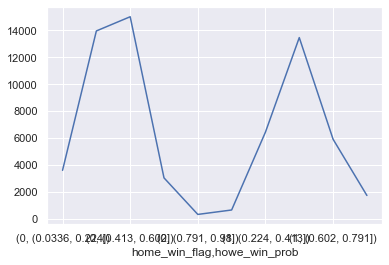

In [231]:
temp.groupby(['home_win_flag', pd.cut(temp.howe_win_prob, 5)]).size().plot()

In [232]:
temp.groupby(['home_win_flag', pd.cut(temp.howe_win_prob, 5)]).size()

home_win_flag  howe_win_prob  
0              (0.0336, 0.224]     3604
               (0.224, 0.413]     13960
               (0.413, 0.602]     15015
               (0.602, 0.791]      3042
               (0.791, 0.98]        327
1              (0.0336, 0.224]      656
               (0.224, 0.413]      6443
               (0.413, 0.602]     13466
               (0.602, 0.791]      5911
               (0.791, 0.98]       1735
dtype: int64

<AxesSubplot:xlabel='draw_flag,draw_prob'>

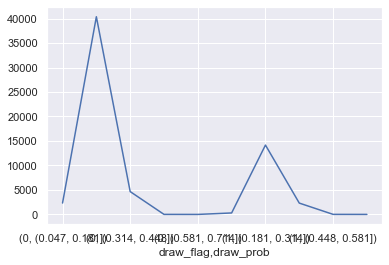

In [233]:
temp.groupby(['draw_flag', pd.cut(temp.draw_prob, 5)]).size().plot()

In [234]:
temp.groupby(['draw_flag', pd.cut(temp.draw_prob, 5)]).size()

draw_flag  draw_prob     
0          (0.047, 0.181]     2324
           (0.181, 0.314]    40365
           (0.314, 0.448]     4663
           (0.448, 0.581]        9
           (0.581, 0.714]        2
1          (0.047, 0.181]      300
           (0.181, 0.314]    14164
           (0.314, 0.448]     2315
           (0.448, 0.581]       12
           (0.581, 0.714]        5
dtype: int64

<AxesSubplot:xlabel='away_win_flag,away_win_prob'>

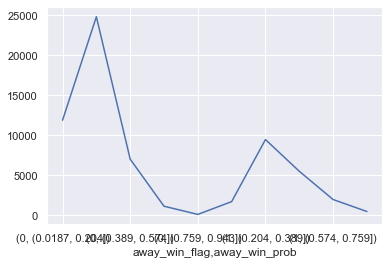

In [235]:
temp.groupby(['away_win_flag', pd.cut(temp.away_win_prob, 5)]).size().plot()

In [236]:
temp.groupby(['away_win_flag', pd.cut(temp.away_win_prob, 5)]).size()

away_win_flag  away_win_prob  
0              (0.0187, 0.204]    11891
               (0.204, 0.389]     24833
               (0.389, 0.574]      7026
               (0.574, 0.759]      1142
               (0.759, 0.943]       115
1              (0.0187, 0.204]     1714
               (0.204, 0.389]      9473
               (0.389, 0.574]      5510
               (0.574, 0.759]      1978
               (0.759, 0.943]       477
dtype: int64

# Measure RAW Odds performance

In [237]:
### Home win
data_eval = temp[['home_win_flag','howe_win_prob']]
#data_eval['howe_win_prob'] = data_eval['howe_win_prob']
data_eval

,home_win_flag,howe_win_prob
0,0,0.578035
1,0,0.800000
2,1,0.636943
3,1,0.854701
4,1,0.854701
...,...,...
64154,0,0.263158
64155,0,0.276243
64156,0,0.181488
64157,0,0.261097


In [238]:
for i in range(0,100):
    cut_value = i/100
    data_eval['pred'] = np.where(data_eval['howe_win_prob']>cut_value,1,0)
    data_eval['correct_flag'] = np.where(data_eval['home_win_flag']==data_eval['pred'],1,0)
    print(sum(data_eval['correct_flag']/len(data_eval)*100))
    print(i)
    

C:\Users\Xtian\AppData\Local\Temp/ipykernel_14416/1838201867.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_eval['pred'] = np.where(data_eval['howe_win_prob']>cut_value,1,0)
C:\Users\Xtian\AppData\Local\Temp/ipykernel_14416/1838201867.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_eval['correct_flag'] = np.where(data_eval['home_win_flag']==data_eval['pred'],1,0)


43.970448417228475
0
43.970448417228475
1
43.970448417228475
2
43.970448417228475
3
43.97980018393307
4
44.000062345126366
5
44.05773157313805
6
44.171511401377316
7
44.313346529730374
8
44.42245047461734
9
44.71235524245986
10
44.84327997632422
11
45.14877102200773
12
45.34671675058837
13
45.64441465735138
14
45.9296435418416
15
46.283452048832196
16
46.655964089231986
17
46.84144079553983
18
47.18278028025763
19
47.751679421453964
20
47.85766611077273
21
48.23797129009302
22
48.638538630606604
23
49.29160367214431
24
49.795040446408464
25
50.05533128635309
26
50.741127511356886
27
51.33340606931471
28
51.87580853818135
29
52.45561807386638
30
53.17258685455217
31
53.71654795120291
32
54.33688180927453
33
55.105285306835604
34
55.97188235479495
35
56.62027151298036
36
57.23904674326788
37
57.92328434048758
38
58.83819884975401
39
59.905858881862194
40
60.244081111011795
41
60.786483579878436
42
61.37876213783626
43
61.99442011255558
44
62.40901510312606
45
62.697361243184474
46
62.993

In [239]:
data_eval['pred'] = np.where(data_eval['howe_win_prob']>0.5,1,0)

roc_auc_score(data_eval['home_win_flag'],data_eval['howe_win_prob'] )

C:\Users\Xtian\AppData\Local\Temp/ipykernel_14416/2948444970.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_eval['pred'] = np.where(data_eval['howe_win_prob']>0.5,1,0)


0.6809836376165735

In [240]:
fpr, tpr, _= roc_curve(data_eval['home_win_flag'],  data_eval['howe_win_prob'])

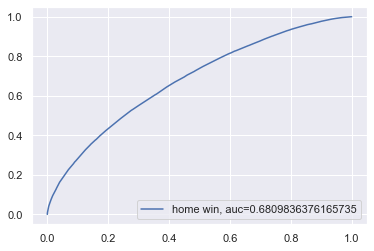

In [241]:
auc = roc_auc_score(data_eval['home_win_flag'],data_eval['howe_win_prob'] )
plt.plot(fpr,tpr,label="home win, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [242]:
### Draw
data_eval = temp[['draw_flag','draw_prob']]
data_eval

,draw_flag,draw_prob
0,0,0.285714
1,1,0.181818
2,0,0.263158
3,0,0.142857
4,0,0.142857
...,...,...
64154,0,0.269542
64155,0,0.292398
64156,0,0.246305
64157,0,0.265957


In [243]:
for i in range(0,100):
    cut_value = i/100
    data_eval['pred'] = np.where(data_eval['draw_prob']>cut_value,1,0)
    data_eval['correct_flag'] = np.where(data_eval['draw_flag']==data_eval['pred'],1,0)
    print(sum(data_eval['correct_flag']/len(data_eval)*100))
    print(i)
    

C:\Users\Xtian\AppData\Local\Temp/ipykernel_14416/1830100541.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_eval['pred'] = np.where(data_eval['draw_prob']>cut_value,1,0)
C:\Users\Xtian\AppData\Local\Temp/ipykernel_14416/1830100541.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_eval['correct_flag'] = np.where(data_eval['draw_flag']==data_eval['pred'],1,0)


26.178712261732205
0
26.178712261732205
1
26.178712261732205
2
26.178712261732205
3
26.178712261732205
4
26.180270889516304
5
26.1942985395732
6
26.23326423417569
7
26.290933462187372
8
26.33613366792626
9
26.509141351961308
10
26.580838230029887
11
26.8723016256565
12
27.135709721169324
13
27.442759394636933
14
27.93216851884419
15
28.47301235992673
16
28.99203541203188
17
29.311554107772285
18
29.987998566071486
19
31.19749372653273
20
31.517012422273137
21
32.44283732602826
22
33.71156034228529
23
35.82038373417197
24
38.13182873799159
25
39.07479854737181
26
43.24724512540629
27
47.72362412134017
28
53.4110569055194
29
61.04677441982306
30
68.23048987671856
31
70.73364609797102
32
72.25486681524524
33
73.26329899155304
34
73.65139730979206
35
73.77764616030355
36
73.8088187159854
37
73.81817048268995
38
73.8275222493945
39
73.83219813274678
40
73.83219813274678
41
73.82596362161041
42
73.8275222493945
43
73.83219813274678
44
73.83063950496269
45
73.8290808771786
46
73.8306395049626

In [244]:
data_eval['pred'] = np.where(data_eval['draw_prob']>0.5,1,0)

roc_auc_score(data_eval['draw_flag'],data_eval['draw_prob'] )

C:\Users\Xtian\AppData\Local\Temp/ipykernel_14416/2029282881.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_eval['pred'] = np.where(data_eval['draw_prob']>0.5,1,0)


0.5656145322201958

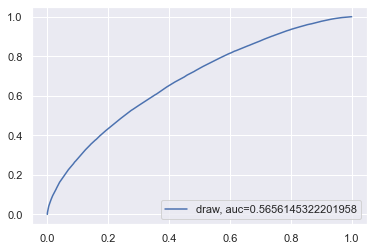

In [245]:
auc = roc_auc_score(data_eval['draw_flag'],data_eval['draw_prob'] )
plt.plot(fpr,tpr,label="draw, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [246]:
### Away win
data_eval = temp[['away_win_flag','away_win_prob']]
data_eval

,away_win_flag,away_win_prob
0,1,0.200000
1,0,0.083333
2,0,0.173913
3,0,0.066667
4,0,0.066667
...,...,...
64154,1,0.526316
64155,1,0.490196
64156,1,0.628931
64157,1,0.534759


In [247]:
for i in range(0,100):
    cut_value = i/100
    data_eval['pred'] = np.where(data_eval['away_win_prob']>cut_value,1,0)
    data_eval['correct_flag'] = np.where(data_eval['away_win_flag']==data_eval['pred'],1,0)
    print(sum(data_eval['correct_flag']/len(data_eval)*100))
    print(i)
    

C:\Users\Xtian\AppData\Local\Temp/ipykernel_14416/2859917764.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_eval['pred'] = np.where(data_eval['away_win_prob']>cut_value,1,0)
C:\Users\Xtian\AppData\Local\Temp/ipykernel_14416/2859917764.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_eval['correct_flag'] = np.where(data_eval['away_win_flag']==data_eval['pred'],1,0)


29.850839321070726
0
29.850839321070726
1
29.852397948854826
2
29.925653454707504
3
30.103337022094852
4
30.41817983448296
5
30.966816814486
6
31.61208871710321
7
32.13267039699245
8
32.637665799040704
9
33.61648404745522
10
34.0092582490483
11
35.182904970475256
12
36.038591623945905
13
36.99714771116712
14
38.17079443259408
15
39.4675727489649
16
41.06672485545103
17
41.68394145795445
18
43.16619648063311
19
45.566483268146406
20
45.909381380648306
21
47.35422933650858
22
49.11859598810926
23
51.44095138641758
24
53.32065649404163
25
53.947224863249644
26
56.095013949738814
27
57.58194485576978
28
59.02991006719825
29
60.37032996152386
30
61.83232282300923
31
63.01687993892488
32
64.17182312694186
33
65.50912576569317
34
66.89006998239907
35
67.61794915757024
36
68.3255661715482
37
68.84303059586689
38
69.65351704359496
39
70.38451347433431
40
70.64480431427775
41
70.95341261552805
42
71.2121448276874
43
71.53945666234681
44
71.74051964649473
45
71.9337894917222
46
72.02730715876774


In [248]:
data_eval['pred'] = np.where(data_eval['away_win_prob']>0.5,1,0)

roc_auc_score(data_eval['away_win_flag'],data_eval['away_win_prob'] )

C:\Users\Xtian\AppData\Local\Temp/ipykernel_14416/2919889408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_eval['pred'] = np.where(data_eval['away_win_prob']>0.5,1,0)


0.6877246848346009

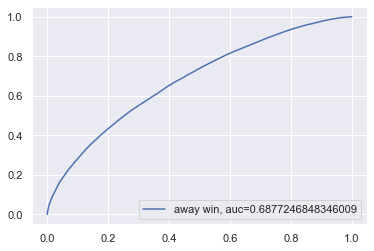

In [249]:
auc = roc_auc_score(data_eval['away_win_flag'],data_eval['away_win_prob'] )
plt.plot(fpr,tpr,label="away win, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Data preprocessing

### Add features

In [250]:
data['home_win_prob'] = 1/data['odds_home_team_win']
data['draw_prob'] = 1/data['odds_draw']
data['away_win_prob'] = 1/data['odds_away_team_win']
data.iloc[:, 2:]

,div,odds_home_team_win,odds_draw,odds_away_team_win,home_team_match_nr,home_team_goal_roll1_sum,home_team_goal_roll2_sum,home_team_goal_roll3_sum,home_team_goal_roll4_sum,home_team_opponents_goal_roll1_sum,...,odds_away_team_defeat_roll3_mean,odds_away_team_defeat_roll4_mean,away_team_point_mean,away_team_expected_point_mean,home_win_flag,draw_flag,away_win_flag,home_win_prob,draw_prob,away_win_prob
0,div0,1.73,3.50,5.00,5,3,7,8,10,0,...,6.377,5.908,0.500,3.000,0,0,1,0.578035,0.285714,0.200000
1,div0,1.25,5.50,12.00,7,0,2,5,9,1,...,2.833,2.475,0.333,0.000,0,1,0,0.800000,0.181818,0.083333
2,div0,1.57,3.80,5.75,9,1,4,4,6,0,...,3.883,3.638,0.750,1.500,1,0,0,0.636943,0.263158,0.173913
3,div0,1.17,7.00,15.00,11,2,6,7,10,1,...,2.333,2.550,0.600,0.000,1,0,0,0.854701,0.142857,0.066667
4,div0,1.17,7.00,15.00,14,2,4,7,9,2,...,2.050,2.015,0.833,0.000,1,0,0,0.854701,0.142857,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64154,div18,3.80,3.71,1.90,30,0,1,3,3,1,...,3.337,3.043,0.929,0.429,0,0,1,0.263158,0.269542,0.526316
64155,div18,3.62,3.42,2.04,32,0,0,0,1,1,...,2.740,2.755,1.000,0.200,0,0,1,0.276243,0.292398,0.490196
64156,div18,5.51,4.06,1.59,34,0,0,0,0,2,...,3.943,3.458,1.312,0.750,0,0,1,0.181488,0.246305,0.628931
64157,div18,3.83,3.76,1.87,36,1,3,3,3,2,...,1.883,1.915,0.412,0.000,0,0,1,0.261097,0.265957,0.534759


In [251]:
dataset = data.copy()
dataset

,match_id,season,div,odds_home_team_win,odds_draw,odds_away_team_win,home_team_match_nr,home_team_goal_roll1_sum,home_team_goal_roll2_sum,home_team_goal_roll3_sum,...,odds_away_team_defeat_roll3_mean,odds_away_team_defeat_roll4_mean,away_team_point_mean,away_team_expected_point_mean,home_win_flag,draw_flag,away_win_flag,home_win_prob,draw_prob,away_win_prob
0,0,2008-2009,div0,1.73,3.50,5.00,5,3,7,8,...,6.377,5.908,0.500,3.000,0,0,1,0.578035,0.285714,0.200000
1,1,2008-2009,div0,1.25,5.50,12.00,7,0,2,5,...,2.833,2.475,0.333,0.000,0,1,0,0.800000,0.181818,0.083333
2,2,2008-2009,div0,1.57,3.80,5.75,9,1,4,4,...,3.883,3.638,0.750,1.500,1,0,0,0.636943,0.263158,0.173913
3,3,2008-2009,div0,1.17,7.00,15.00,11,2,6,7,...,2.333,2.550,0.600,0.000,1,0,0,0.854701,0.142857,0.066667
4,4,2008-2009,div0,1.17,7.00,15.00,14,2,4,7,...,2.050,2.015,0.833,0.000,1,0,0,0.854701,0.142857,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64154,64395,2021-2022,div18,3.80,3.71,1.90,30,0,1,3,...,3.337,3.043,0.929,0.429,0,0,1,0.263158,0.269542,0.526316
64155,64396,2021-2022,div18,3.62,3.42,2.04,32,0,0,0,...,2.740,2.755,1.000,0.200,0,0,1,0.276243,0.292398,0.490196
64156,64397,2021-2022,div18,5.51,4.06,1.59,34,0,0,0,...,3.943,3.458,1.312,0.750,0,0,1,0.181488,0.246305,0.628931
64157,64398,2021-2022,div18,3.83,3.76,1.87,36,1,3,3,...,1.883,1.915,0.412,0.000,0,0,1,0.261097,0.265957,0.534759


### Div grouping

In [252]:
div_mean_home_flag = dataset.iloc[:, 2:].groupby(['div','home_win_flag']).mean().reset_index()
div_mean_home_flag = div_mean_home_flag.add_suffix('_div_mean_home_flag')
div_mean_home_flag = div_mean_home_flag[div_mean_home_flag['home_win_flag_div_mean_home_flag']==0].reset_index(drop=True)
div_mean_home_flag = div_mean_home_flag.rename(columns={"div_div_mean_home_flag": "div"})
div_mean_home_flag

,div,home_win_flag_div_mean_home_flag,odds_home_team_win_div_mean_home_flag,odds_draw_div_mean_home_flag,odds_away_team_win_div_mean_home_flag,home_team_match_nr_div_mean_home_flag,home_team_goal_roll1_sum_div_mean_home_flag,home_team_goal_roll2_sum_div_mean_home_flag,home_team_goal_roll3_sum_div_mean_home_flag,home_team_goal_roll4_sum_div_mean_home_flag,...,odds_away_team_defeat_roll2_mean_div_mean_home_flag,odds_away_team_defeat_roll3_mean_div_mean_home_flag,odds_away_team_defeat_roll4_mean_div_mean_home_flag,away_team_point_mean_div_mean_home_flag,away_team_expected_point_mean_div_mean_home_flag,draw_flag_div_mean_home_flag,away_win_flag_div_mean_home_flag,home_win_prob_div_mean_home_flag,draw_prob_div_mean_home_flag,away_win_prob_div_mean_home_flag
0,div0,0,3.161356,3.883859,3.458075,19.409069,1.232996,2.669561,3.936807,5.331886,...,4.073379,4.221616,4.082497,1.231789,1.113919,0.441872,0.558128,0.413263,0.267105,0.375733
1,div1,0,3.459845,3.879025,3.637297,21.273786,1.164660,2.448544,3.700971,4.952621,...,4.635571,4.585792,4.573325,1.295617,1.196732,0.449709,0.550291,0.391462,0.267353,0.380666
2,div10,0,2.519974,3.531901,3.209681,19.311224,1.321429,2.743622,4.048469,5.485969,...,3.000721,3.060337,2.986820,1.238848,0.844131,0.482143,0.517857,0.431748,0.285444,0.346906
3,div11,0,2.455719,3.190981,3.450466,21.576809,1.095144,2.378593,3.550050,4.779980,...,3.163543,3.241611,3.148992,1.143259,0.671497,0.547076,0.452924,0.434782,0.315508,0.317873
4,div12,0,3.838038,4.265398,3.313599,18.809735,1.258112,2.733038,4.106195,5.452802,...,4.886187,4.900541,4.859706,1.354494,1.341491,0.414454,0.585546,0.387524,0.248482,0.425399
5,div13,0,3.760027,3.681046,3.177212,19.525469,1.057641,2.254692,3.317694,4.520107,...,4.623056,4.755594,4.617007,1.351276,1.142138,0.427614,0.572386,0.374198,0.282230,0.407933
6,div14,0,2.828159,3.540909,3.073473,18.902098,1.251748,2.449883,3.685315,4.965035,...,3.252319,3.175350,3.188960,1.265524,1.132970,0.475524,0.524476,0.411328,0.286100,0.376390
7,div15,0,2.760746,3.697943,2.998458,18.804627,1.349614,2.791774,4.257069,5.534704,...,3.180514,3.169869,3.180095,1.288645,1.203111,0.416452,0.583548,0.414051,0.273177,0.391482
8,div16,0,3.115638,3.758087,2.921684,19.153061,1.283163,2.507653,3.854592,5.163265,...,3.480242,3.439699,3.436436,1.423372,1.229645,0.375000,0.625000,0.394658,0.270508,0.413404
9,div17,0,2.456464,3.113069,3.612813,23.237213,0.970018,2.206349,3.237213,4.395944,...,3.220520,3.355078,3.222009,1.080168,0.571117,0.549383,0.450617,0.436198,0.323797,0.308558


In [253]:
div_mean = dataset.iloc[:, 2:].groupby('div').mean().reset_index()
div_mean = div_mean.add_suffix('_div_mean')
div_mean = div_mean.rename(columns={"div_div_mean": "div"})

div_median = dataset.iloc[:, 2:].groupby('div').median().reset_index()
div_median = div_median.add_suffix('_div_median')
div_median = div_median.rename(columns={"div_div_median": "div"})

In [254]:
div_mean

,div,odds_home_team_win_div_mean,odds_draw_div_mean,odds_away_team_win_div_mean,home_team_match_nr_div_mean,home_team_goal_roll1_sum_div_mean,home_team_goal_roll2_sum_div_mean,home_team_goal_roll3_sum_div_mean,home_team_goal_roll4_sum_div_mean,home_team_opponents_goal_roll1_sum_div_mean,...,odds_away_team_defeat_roll3_mean_div_mean,odds_away_team_defeat_roll4_mean_div_mean,away_team_point_mean_div_mean,away_team_expected_point_mean_div_mean,home_win_flag_div_mean,draw_flag_div_mean,away_win_flag_div_mean,home_win_prob_div_mean,draw_prob_div_mean,away_win_prob_div_mean
0,div0,2.710765,4.054641,4.395015,19.503308,1.321778,2.905001,4.273088,5.802064,1.615242,...,3.759038,3.630366,1.163573,0.928638,0.451442,0.242392,0.306166,0.469867,0.260408,0.325857
1,div1,2.872319,4.113198,4.957965,21.526404,1.247843,2.632863,3.993688,5.343783,1.478855,...,4.045265,4.019310,1.187043,0.962192,0.458237,0.243636,0.298127,0.464259,0.257989,0.317273
2,div10,2.412374,3.563702,3.393561,19.520030,1.341988,2.856825,4.232938,5.683976,1.549703,...,3.004024,2.934130,1.197985,0.753005,0.418398,0.280415,0.301187,0.449723,0.283308,0.331183
3,div11,2.334370,3.236425,3.724927,21.758561,1.153221,2.471851,3.679629,4.950667,1.379571,...,3.156189,3.067059,1.100174,0.581942,0.414393,0.320371,0.265235,0.457446,0.311778,0.298953
4,div12,3.015000,4.589575,5.061283,18.934646,1.407874,3.024409,4.514173,6.070079,1.684252,...,4.177580,4.127259,1.219406,1.090102,0.466142,0.221260,0.312598,0.479192,0.239009,0.343430
5,div13,3.019429,3.958325,4.697650,19.509266,1.177168,2.535211,3.733877,5.067457,1.376575,...,4.049199,3.929483,1.201792,0.870069,0.446998,0.236471,0.316531,0.459740,0.270985,0.333710
6,div14,2.588322,3.611848,3.516460,19.094499,1.266573,2.541608,3.784203,5.119887,1.282087,...,3.078784,3.086478,1.214987,1.048030,0.394922,0.287729,0.317348,0.445754,0.282045,0.345885
7,div15,2.513980,3.747157,3.382609,18.874636,1.377551,2.776968,4.244898,5.654519,1.516035,...,2.995736,3.001612,1.241695,1.041519,0.432945,0.236152,0.330904,0.452639,0.270102,0.355858
8,div16,2.709074,3.880029,3.670647,18.873529,1.376471,2.738235,4.167647,5.535294,1.380882,...,3.208537,3.197047,1.317810,1.067385,0.423529,0.216176,0.360294,0.454651,0.264587,0.359522
9,div17,2.328719,3.162444,3.873817,23.350929,0.992669,2.241935,3.282014,4.481916,1.272727,...,3.272159,3.149544,1.060162,0.501769,0.445748,0.304497,0.249756,0.459577,0.319286,0.289624


In [255]:
div_median

,div,odds_home_team_win_div_median,odds_draw_div_median,odds_away_team_win_div_median,home_team_match_nr_div_median,home_team_goal_roll1_sum_div_median,home_team_goal_roll2_sum_div_median,home_team_goal_roll3_sum_div_median,home_team_goal_roll4_sum_div_median,home_team_opponents_goal_roll1_sum_div_median,...,odds_away_team_defeat_roll3_mean_div_median,odds_away_team_defeat_roll4_mean_div_median,away_team_point_mean_div_median,away_team_expected_point_mean_div_median,home_win_flag_div_median,draw_flag_div_median,away_win_flag_div_median,home_win_prob_div_median,draw_prob_div_median,away_win_prob_div_median
0,div0,2.200,3.60,3.300,20.0,1.0,3.0,4.0,5.0,1.0,...,2.9000,2.7930,1.125,0.5000,0.0,0.0,0.0,0.454545,0.277778,0.303030
1,div1,2.200,3.60,3.500,22.0,1.0,2.0,4.0,5.0,1.0,...,2.9000,2.8880,1.091,0.4290,0.0,0.0,0.0,0.454545,0.277778,0.285714
2,div10,2.275,3.46,3.100,20.0,1.0,3.0,4.0,5.0,1.0,...,2.8230,2.7480,1.154,0.4000,0.0,0.0,0.0,0.439563,0.289017,0.322581
3,div11,2.200,3.16,3.490,22.0,1.0,2.0,3.0,5.0,1.0,...,3.0070,2.9220,1.083,0.2500,0.0,0.0,0.0,0.454545,0.316456,0.286533
4,div12,2.140,3.84,3.220,19.0,1.0,3.0,4.0,5.0,1.0,...,2.7685,2.7220,1.182,0.7500,0.0,0.0,0.0,0.467290,0.260417,0.310559
5,div13,2.240,3.40,3.370,20.0,1.0,2.0,3.0,5.0,1.0,...,2.7770,2.6620,1.000,0.2310,0.0,0.0,0.0,0.446429,0.294118,0.296736
6,div14,2.300,3.45,2.980,19.0,1.0,2.0,4.0,5.0,1.0,...,2.8170,2.8620,1.200,1.0000,0.0,0.0,0.0,0.434783,0.289855,0.335570
7,div15,2.250,3.60,2.900,18.0,1.0,3.0,4.0,5.0,1.0,...,2.5950,2.6125,1.207,0.7500,0.0,0.0,0.0,0.444444,0.277778,0.344828
8,div16,2.250,3.60,2.880,18.0,1.0,2.0,4.0,5.0,1.0,...,2.7065,2.7300,1.267,1.0000,0.0,0.0,0.0,0.444444,0.277778,0.347222
9,div17,2.200,3.10,3.500,23.0,1.0,2.0,3.0,4.0,1.0,...,3.0850,2.9900,1.000,0.2000,0.0,0.0,0.0,0.454545,0.322581,0.285714


In [256]:
dataset = dataset.merge(div_mean, on = 'div', how='left')
dataset = dataset.merge(div_median, on = 'div', how='left')
dataset = dataset.merge(div_mean_home_flag, on = 'div', how='left')
print(dataset.shape)
dataset

(64159, 671)


,match_id,season,div,odds_home_team_win,odds_draw,odds_away_team_win,home_team_match_nr,home_team_goal_roll1_sum,home_team_goal_roll2_sum,home_team_goal_roll3_sum,...,odds_away_team_defeat_roll2_mean_div_mean_home_flag,odds_away_team_defeat_roll3_mean_div_mean_home_flag,odds_away_team_defeat_roll4_mean_div_mean_home_flag,away_team_point_mean_div_mean_home_flag,away_team_expected_point_mean_div_mean_home_flag,draw_flag_div_mean_home_flag,away_win_flag_div_mean_home_flag,home_win_prob_div_mean_home_flag,draw_prob_div_mean_home_flag,away_win_prob_div_mean_home_flag
0,0,2008-2009,div0,1.73,3.50,5.00,5,3,7,8,...,4.073379,4.221616,4.082497,1.231789,1.113919,0.441872,0.558128,0.413263,0.267105,0.375733
1,1,2008-2009,div0,1.25,5.50,12.00,7,0,2,5,...,4.073379,4.221616,4.082497,1.231789,1.113919,0.441872,0.558128,0.413263,0.267105,0.375733
2,2,2008-2009,div0,1.57,3.80,5.75,9,1,4,4,...,4.073379,4.221616,4.082497,1.231789,1.113919,0.441872,0.558128,0.413263,0.267105,0.375733
3,3,2008-2009,div0,1.17,7.00,15.00,11,2,6,7,...,4.073379,4.221616,4.082497,1.231789,1.113919,0.441872,0.558128,0.413263,0.267105,0.375733
4,4,2008-2009,div0,1.17,7.00,15.00,14,2,4,7,...,4.073379,4.221616,4.082497,1.231789,1.113919,0.441872,0.558128,0.413263,0.267105,0.375733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64154,64395,2021-2022,div18,3.80,3.71,1.90,30,0,1,3,...,3.384319,3.516837,3.373006,1.161146,1.044217,0.471084,0.528916,0.422109,0.281128,0.361559
64155,64396,2021-2022,div18,3.62,3.42,2.04,32,0,0,0,...,3.384319,3.516837,3.373006,1.161146,1.044217,0.471084,0.528916,0.422109,0.281128,0.361559
64156,64397,2021-2022,div18,5.51,4.06,1.59,34,0,0,0,...,3.384319,3.516837,3.373006,1.161146,1.044217,0.471084,0.528916,0.422109,0.281128,0.361559
64157,64398,2021-2022,div18,3.83,3.76,1.87,36,1,3,3,...,3.384319,3.516837,3.373006,1.161146,1.044217,0.471084,0.528916,0.422109,0.281128,0.361559


In [257]:
pd.DataFrame(dataset.columns)

,0
0,match_id
1,season
2,div
3,odds_home_team_win
4,odds_draw
5,odds_away_team_win
6,home_team_match_nr
7,home_team_goal_roll1_sum
8,home_team_goal_roll2_sum
9,home_team_goal_roll3_sum


In [258]:
dataset.iloc[:, 3:164]

,odds_home_team_win,odds_draw,odds_away_team_win,home_team_match_nr,home_team_goal_roll1_sum,home_team_goal_roll2_sum,home_team_goal_roll3_sum,home_team_goal_roll4_sum,home_team_opponents_goal_roll1_sum,home_team_opponents_goal_roll2_sum,...,odds_away_team_draw_roll1_mean,odds_away_team_draw_roll2_mean,odds_away_team_draw_roll3_mean,odds_away_team_draw_roll4_mean,odds_away_team_defeat_roll1_mean,odds_away_team_defeat_roll2_mean,odds_away_team_defeat_roll3_mean,odds_away_team_defeat_roll4_mean,away_team_point_mean,away_team_expected_point_mean
0,1.73,3.50,5.00,5,3,7,8,10,0,1,...,5.00,4.250,3.933,3.825,11.00,7.665,6.377,5.908,0.500,3.000
1,1.25,5.50,12.00,7,0,2,5,9,1,6,...,3.30,3.300,3.333,3.582,2.10,2.250,2.833,2.475,0.333,0.000
2,1.57,3.80,5.75,9,1,4,4,6,0,3,...,4.00,3.750,3.600,3.525,6.75,4.275,3.883,3.638,0.750,1.500
3,1.17,7.00,15.00,11,2,6,7,10,1,3,...,3.40,4.325,4.217,3.975,4.20,2.750,2.333,2.550,0.600,0.000
4,1.17,7.00,15.00,14,2,4,7,9,2,3,...,3.30,4.400,4.100,3.925,3.10,2.175,2.050,2.015,0.833,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64154,3.80,3.71,1.90,30,0,1,3,3,1,1,...,4.09,3.725,3.620,3.558,5.04,3.695,3.337,3.043,0.929,0.429
64155,3.62,3.42,2.04,32,0,0,0,1,1,3,...,3.16,3.225,3.250,3.268,3.03,2.585,2.740,2.755,1.000,0.200
64156,5.51,4.06,1.59,34,0,0,0,0,2,3,...,3.74,3.675,3.670,3.625,4.19,3.860,3.943,3.458,1.312,0.750
64157,3.83,3.76,1.87,36,1,3,3,3,2,5,...,3.60,3.905,3.780,3.738,2.04,1.800,1.883,1.915,0.412,0.000


# Train, test split

In [259]:
dataset

,match_id,season,div,odds_home_team_win,odds_draw,odds_away_team_win,home_team_match_nr,home_team_goal_roll1_sum,home_team_goal_roll2_sum,home_team_goal_roll3_sum,...,odds_away_team_defeat_roll2_mean_div_mean_home_flag,odds_away_team_defeat_roll3_mean_div_mean_home_flag,odds_away_team_defeat_roll4_mean_div_mean_home_flag,away_team_point_mean_div_mean_home_flag,away_team_expected_point_mean_div_mean_home_flag,draw_flag_div_mean_home_flag,away_win_flag_div_mean_home_flag,home_win_prob_div_mean_home_flag,draw_prob_div_mean_home_flag,away_win_prob_div_mean_home_flag
0,0,2008-2009,div0,1.73,3.50,5.00,5,3,7,8,...,4.073379,4.221616,4.082497,1.231789,1.113919,0.441872,0.558128,0.413263,0.267105,0.375733
1,1,2008-2009,div0,1.25,5.50,12.00,7,0,2,5,...,4.073379,4.221616,4.082497,1.231789,1.113919,0.441872,0.558128,0.413263,0.267105,0.375733
2,2,2008-2009,div0,1.57,3.80,5.75,9,1,4,4,...,4.073379,4.221616,4.082497,1.231789,1.113919,0.441872,0.558128,0.413263,0.267105,0.375733
3,3,2008-2009,div0,1.17,7.00,15.00,11,2,6,7,...,4.073379,4.221616,4.082497,1.231789,1.113919,0.441872,0.558128,0.413263,0.267105,0.375733
4,4,2008-2009,div0,1.17,7.00,15.00,14,2,4,7,...,4.073379,4.221616,4.082497,1.231789,1.113919,0.441872,0.558128,0.413263,0.267105,0.375733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64154,64395,2021-2022,div18,3.80,3.71,1.90,30,0,1,3,...,3.384319,3.516837,3.373006,1.161146,1.044217,0.471084,0.528916,0.422109,0.281128,0.361559
64155,64396,2021-2022,div18,3.62,3.42,2.04,32,0,0,0,...,3.384319,3.516837,3.373006,1.161146,1.044217,0.471084,0.528916,0.422109,0.281128,0.361559
64156,64397,2021-2022,div18,5.51,4.06,1.59,34,0,0,0,...,3.384319,3.516837,3.373006,1.161146,1.044217,0.471084,0.528916,0.422109,0.281128,0.361559
64157,64398,2021-2022,div18,3.83,3.76,1.87,36,1,3,3,...,3.384319,3.516837,3.373006,1.161146,1.044217,0.471084,0.528916,0.422109,0.281128,0.361559


In [260]:
y = dataset['home_win_flag']

X = dataset.copy()
X = X.drop(['home_win_flag'], axis=1)
X = X.drop(['draw_flag'], axis=1)
X = X.drop(['away_win_flag'], axis=1)
X = X.drop(['season'], axis=1)
X = X.drop(['div'], axis=1)
X = X.drop(['match_id'], axis=1)

X = X.drop(['odds_home_team_win'], axis=1)
X = X.drop(['odds_draw'], axis=1)
X = X.drop(['odds_away_team_win'], axis=1)

X = X.drop(['home_win_prob'], axis=1)
X = X.drop(['draw_prob'], axis=1)
X = X.drop(['away_win_prob'], axis=1)

In [261]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state=1)
X_train.shape[1]

659

### Previous version

In [ ]:
### Train 

data_y1= dataset[dataset['home_win_flag']==1].reset_index(drop=True)
data_y0= dataset[dataset['home_win_flag']==0].reset_index(drop=True)

### home win col 164
data_to_train = pd.concat([data_y1[0:20000],data_y0[0:20000]], ignore_index=True)

y_train = data_to_train.iloc[:, 164].values

X_train = data_to_train.drop(['home_win_flag'], axis=1)
X_train = X_train.drop(['draw_flag'], axis=1)
X_train = X_train.drop(['away_win_flag'], axis=1)
X_train = X_train.iloc[:, 3:len(X_train)].values

### Test

data_to_test = pd.concat([data_y1[20000:28000],data_y0[20000:28000]], ignore_index=True)

y_test = data_to_test.iloc[:, 164].values

X_test = data_to_test.drop(['home_win_flag'], axis=1)
X_test = X_test.drop(['draw_flag'], axis=1)
X_test = X_test.drop(['away_win_flag'], axis=1)
X_test = X_test.iloc[:, 3:len(X_test)].values

# Modeling WIP

### Random forest

In [262]:
clf = RandomForestClassifier(random_state=0,  max_depth= 20)#n_estimators= 100,
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, random_state=0)

In [263]:
for name, importance in zip(X.columns, clf.feature_importances_):
    print(name, "=", importance)

home_team_match_nr = 0.006520397985508013
home_team_goal_roll1_sum = 0.002646872593020127
home_team_goal_roll2_sum = 0.003473122667338926
home_team_goal_roll3_sum = 0.00423710854057201
home_team_goal_roll4_sum = 0.005140281988941758
home_team_opponents_goal_roll1_sum = 0.0026772552953875993
home_team_opponents_goal_roll2_sum = 0.003766521311369524
home_team_opponents_goal_roll3_sum = 0.0040532909283862665
home_team_opponents_goal_roll4_sum = 0.004532077423232561
home_team_shot_roll1_sum = 0.005855865259952731
home_team_shot_roll2_sum = 0.0063611913623803275
home_team_shot_roll3_sum = 0.006819887889571315
home_team_shot_roll4_sum = 0.007527730080772176
home_team_opponents_shot_roll1_sum = 0.005658416422426498
home_team_opponents_shot_roll2_sum = 0.006409429885587126
home_team_opponents_shot_roll3_sum = 0.006678110746178173
home_team_opponents_shot_roll4_sum = 0.006726873162418861
home_team_shot_on_target_roll1_sum = 0.004504835754814284
home_team_shot_on_target_roll2_sum = 0.00545839558

<AxesSubplot:>

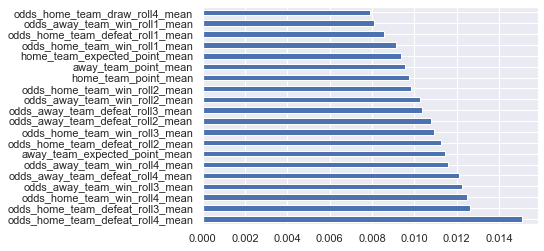

In [264]:
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [267]:
preds = clf.predict(X_test)
preds

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [268]:
print (clf.score(X_test, y_test))

0.6204280964256027


In [269]:
sklearn.metrics.confusion_matrix(y_test, preds)

array([[8472, 2354],
       [4952, 3470]], dtype=int64)

In [271]:
roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

0.6548982999711812

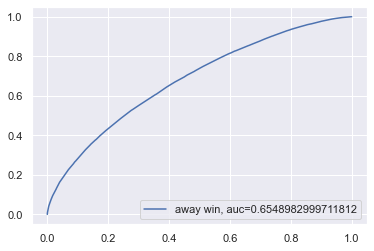

In [272]:
auc = roc_auc_score(y_test,clf.predict_proba(X_test)[:,1] )
plt.plot(fpr,tpr,label="away win, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [188]:
param_dist = {'n_estimators': [100],
              'max_depth': [20]}

# Create a random forest classifier
clf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(clf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

D:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=5. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': [20],
                                        'n_estimators': [100]})

In [189]:
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'n_estimators': 100, 'max_depth': 20}


## Keras

In [273]:
#model = Sequential() 
#model.add(Dense(128, activation='relu', input_dim=498))
#model.add(Dense(1, activation='sigmoid')) 
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','AUC']) 
#model.summary()

model = Sequential()
model.add(Dense(500, activation='relu', input_dim=659))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy','AUC'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 500)               330000    
                                                                 
 dense_13 (Dense)            (None, 100)               50100     
                                                                 
 dense_14 (Dense)            (None, 50)                5050      
                                                                 
 dense_15 (Dense)            (None, 1)                 51        
                                                                 
Total params: 385,201
Trainable params: 385,201
Non-trainable params: 0
_________________________________________________________________


In [274]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=1000)

Epoch 1/100
45/45 [==============================] - 2s 22ms/step - loss: 1.1230 - accuracy: 0.5461 - auc: 0.5447 - val_loss: 0.6542 - val_accuracy: 0.6087 - val_auc: 0.6391
Epoch 2/100
45/45 [==============================] - 1s 17ms/step - loss: 0.6601 - accuracy: 0.6032 - auc: 0.6329 - val_loss: 0.6494 - val_accuracy: 0.6135 - val_auc: 0.6500
Epoch 3/100
45/45 [==============================] - 1s 17ms/step - loss: 0.6797 - accuracy: 0.5899 - auc: 0.6160 - val_loss: 0.7017 - val_accuracy: 0.5474 - val_auc: 0.6543
Epoch 4/100
45/45 [==============================] - 1s 16ms/step - loss: 0.6820 - accuracy: 0.5862 - auc: 0.6127 - val_loss: 0.7405 - val_accuracy: 0.5125 - val_auc: 0.6559
Epoch 5/100
45/45 [==============================] - 1s 16ms/step - loss: 0.6683 - accuracy: 0.5983 - auc: 0.6266 - val_loss: 0.6453 - val_accuracy: 0.6152 - val_auc: 0.6582
Epoch 6/100
45/45 [==============================] - 1s 16ms/step - loss: 0.6507 - accuracy: 0.6121 - auc: 0.6474 - val_loss: 0.65

Epoch 48/100
45/45 [==============================] - 1s 16ms/step - loss: 0.6390 - accuracy: 0.6292 - auc: 0.6677 - val_loss: 0.6399 - val_accuracy: 0.6262 - val_auc: 0.6643
Epoch 49/100
45/45 [==============================] - 1s 16ms/step - loss: 0.6396 - accuracy: 0.6295 - auc: 0.6673 - val_loss: 0.6418 - val_accuracy: 0.6225 - val_auc: 0.6638
Epoch 50/100
45/45 [==============================] - 1s 16ms/step - loss: 0.6415 - accuracy: 0.6231 - auc: 0.6633 - val_loss: 0.6399 - val_accuracy: 0.6267 - val_auc: 0.6646
Epoch 51/100
45/45 [==============================] - 1s 16ms/step - loss: 0.6406 - accuracy: 0.6265 - auc: 0.6647 - val_loss: 0.6398 - val_accuracy: 0.6285 - val_auc: 0.6644
Epoch 52/100
45/45 [==============================] - 1s 17ms/step - loss: 0.6411 - accuracy: 0.6265 - auc: 0.6639 - val_loss: 0.6414 - val_accuracy: 0.6275 - val_auc: 0.6645
Epoch 53/100
45/45 [==============================] - 1s 16ms/step - loss: 0.6427 - accuracy: 0.6237 - auc: 0.6609 - val_loss

Epoch 95/100
45/45 [==============================] - 1s 17ms/step - loss: 0.6398 - accuracy: 0.6261 - auc: 0.6657 - val_loss: 0.6396 - val_accuracy: 0.6290 - val_auc: 0.6656
Epoch 96/100
45/45 [==============================] - 1s 16ms/step - loss: 0.6391 - accuracy: 0.6290 - auc: 0.6671 - val_loss: 0.6415 - val_accuracy: 0.6213 - val_auc: 0.6652
Epoch 97/100
45/45 [==============================] - 1s 16ms/step - loss: 0.6387 - accuracy: 0.6284 - auc: 0.6677 - val_loss: 0.6401 - val_accuracy: 0.6273 - val_auc: 0.6646
Epoch 98/100
45/45 [==============================] - 1s 16ms/step - loss: 0.6409 - accuracy: 0.6262 - auc: 0.6638 - val_loss: 0.6450 - val_accuracy: 0.6156 - val_auc: 0.6649
Epoch 99/100
45/45 [==============================] - 1s 16ms/step - loss: 0.6402 - accuracy: 0.6276 - auc: 0.6654 - val_loss: 0.6421 - val_accuracy: 0.6227 - val_auc: 0.6650
Epoch 100/100
45/45 [==============================] - 1s 16ms/step - loss: 0.6418 - accuracy: 0.6254 - auc: 0.6625 - val_los

In [278]:
model.predict(X_train)

1404/1404 [==============================] - 2s 1ms/step


array([[0.38478237],
       [0.6235104 ],
       [0.5917228 ],
       ...,
       [0.24201097],
       [0.77753603],
       [0.38459158]], dtype=float32)

In [276]:
y_test

41558    1
3027     1
8249     0
16742    0
39326    1
        ..
49544    1
51893    1
24012    1
41532    0
45260    0
Name: home_win_flag, Length: 19248, dtype: int64

602/602 [==============================] - 1s 1ms/step


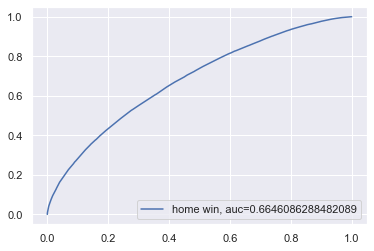

In [281]:
auc = roc_auc_score(y_test,model.predict(X_test) )
plt.plot(fpr,tpr,label="home win, auc="+str(auc))
plt.legend(loc=4)
plt.show()

[]

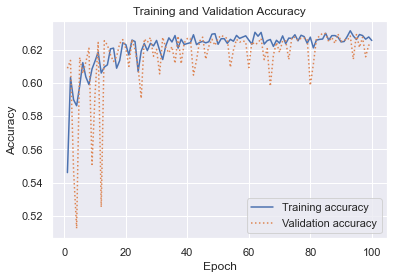

In [282]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
 
acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

602/602 [==============================] - 1s 1ms/step


Text(89.18, 0.5, 'Actual')

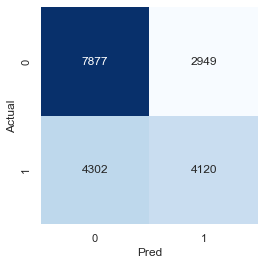

In [283]:

y_predicted = model.predict(X_test) > 0.5
mat = confusion_matrix(y_test, y_predicted)
labels = ['0', '1']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Pred')
plt.ylabel('Actual')

In [284]:
fpr, tpr, thresholds= metrics.roc_curve(y_test, model.predict(X_test),pos_label=1)

602/602 [==============================] - 1s 1ms/step


In [285]:
metrics.auc(fpr, tpr)

0.6646086288482089

602/602 [==============================] - 1s 1ms/step


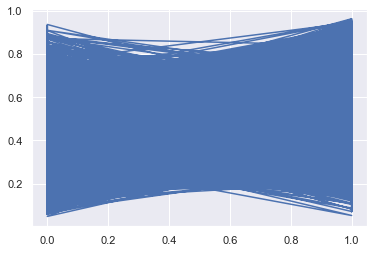

In [286]:
plt.plot(y_test,model.predict(X_test))
plt.show() 